In [1]:
import pickle
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.models import Model, load_model
from keras.layers import LSTM, Dense, TimeDistributed, Input, Masking, RepeatVector, Bidirectional, Embedding

Using TensorFlow backend.


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import csv
import os

In [3]:
# import tensorflow as tf
# tf.test.gpu_device_name()

In [4]:
## HYPER-PARAMETERS

num_words = 10000
MAX_SEQUENCE_LENGTH = 16
WORD_EMBEDDING_DIM = 200
batch_size = 640
ENCODING_DIM = 500
NUM_DATAPOINT = -1 # All in the file
NUM_ICD_CODES = 100
NUM_EPOCHS = 2
VALIDATION_SPLIT = 0.2
PATIENCE = 5
TOP_K_PER_SENTENCE = 10

THRESHOLD = -1 # TODO

ICD_DESC_FILENAME = './Description/ICD_desc_with_freq.csv'
DD_FILENAME = 'MIMIC_III_Final_1000_clean_shorted.csv'
TOKENIZER_FILE = 'tokenizer.pickle'
EMB_FILE = './Embedding/PMC-w2v.bin'

RESULT_FILENAME = './result.csv'
#http://yaronvazana.com/2019/09/28/training-an-autoencoder-to-generate-text-embeddings/

### ICD code description file

In [5]:
ICD_desc_filename = ICD_DESC_FILENAME
df_icd = pd.read_csv(ICD_desc_filename, encoding = 'latin1')
print(df_icd.shape)
print(df_icd.columns)
print(df_icd.head())

(6553, 4)
Index(['Unnamed: 0', 'Code', 'Long Description', 'Frequency'], dtype='object')
   Unnamed: 0   Code                                   Long Description  \
0           0   4019                 Unspecified essential hypertension   
1           1   4280              Congestive heart failure, unspecified   
2           2  42731                                Atrial fibrillation   
3           3  41401  Coronary atherosclerosis of native coronary ar...   
4           4   5849                  Acute kidney failure, unspecified   

   Frequency  
0      20053  
1      12842  
2      12594  
3      12179  
4       8907  


In [6]:
icd_sentences = list(df_icd.head(NUM_ICD_CODES)['Long Description']) # Number of sentences
icd_codes = list(df_icd.head(NUM_ICD_CODES)['Code'])
icd_index = list(range(NUM_ICD_CODES))

print(len(icd_sentences), len(icd_codes), len(icd_index))
print("ICD_Sentences = ", len(icd_sentences))

100 100 100
ICD_Sentences =  100


In [7]:
# 3 Dictionary of ICD index, ICD Code and ICD desc

# index, codes
dict_index_code = dict(zip(icd_index, icd_codes))

# codes, index
dict_code_index = dict(zip(icd_codes, icd_index))

#index, code desc
dict_index_desc = dict(zip(icd_index, icd_sentences))

### Cleaned MIMIC-III DD file

In [8]:
DD_filename = DD_FILENAME
df_DD = pd.read_csv(DD_filename)
df_DD.head()

,Unnamed: 0,Unnamed: 0.1,TEXT,HADM_ID,ICD9_CODE,clean_text
0,38424,38424,{Admission Date: [**2164-3-14**] ...,172931.0,"['5160', '3485', '51851', '486', '2762', '5180...",discharge diagnosis pulmonary alveolar protein...
1,2209,2209,{Admission Date: [**2110-7-7**] Dischar...,104113.0,['4240'],discharge diagnosis status post mitral valve r...
2,37528,37528,{Admission Date: [**2123-10-4**] ...,171221.0,"['73028', '2851', '3004', '73719', '72293']",discharge diagnosis osteomyelitis l postoperat...
3,40528,40528,{Admission Date: [**2192-9-18**] ...,176918.0,"['9982', '7907', '99811', '70703', '70722', '5...",discharge diagnosis cbd injury sp ccy at osh r...
4,41885,41885,{Admission Date: [**2107-3-7**] ...,179390.0,"['40391', '5856', '99681', '25002']",discharge diagnosis esrd delayed graft functio...


In [9]:
DD_sentences = []
for ind, row in df_DD.iterrows():
    text = row['clean_text']
    DD_sent = sent_tokenize(text)
    DD_sentences = DD_sentences + DD_sent 
    
print("DD_sentences = ", len(DD_sentences))
    

DD_sentences =  36185


In [10]:
all_sentences = icd_sentences + DD_sentences

### Tokenizer

In [11]:
tokenizer = Tokenizer(num_words = num_words, split=' ')
tokenizer.fit_on_texts(all_sentences)
seqs = tokenizer.texts_to_sequences(all_sentences)
pad_seqs = pad_sequences(seqs, MAX_SEQUENCE_LENGTH, padding='post')

In [12]:
# SAVE tokenizer in a pickle file
with open(TOKENIZER_FILE, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Pre-Trained Word Embedding

In [13]:
from gensim.models.keyedvectors import KeyedVectors
word_model = KeyedVectors.load_word2vec_format(EMB_FILE, binary=True)

In [14]:
print('Found %s word vectors.' % len(word_model.index2word))
print(word_model['Cholera'].shape)

Found 2515686 word vectors.
(200,)


In [15]:
# cosine_similarity([word_model['birth']],[word_model['born']] )

In [16]:
word_index = tokenizer.word_index
num_words  = len(word_index) + 1
print("num_words = ", num_words)

num_words =  10450


### Bi-LSTM Encoder-Decoder Model

In [17]:
embedding_matrix = np.zeros((len(word_index) + 1, WORD_EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word_model.vocab:
        embedding_matrix[i] = word_model[word]

In [18]:
emb_layer = Embedding(len(word_index) + 1, WORD_EMBEDDING_DIM, 
                      weights=[embedding_matrix],
                      input_length = MAX_SEQUENCE_LENGTH, name='Body-Word-Embedding',
                      mask_zero = True, 
                     trainable=False)

In [19]:
print(len(word_index) + 1, num_words, embedding_matrix.shape )

10450 10450 (10450, 200)


In [20]:
encoder_inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), name='Encoder-Input')

x = emb_layer(encoder_inputs)
state_h = Bidirectional(LSTM(ENCODING_DIM//2, activation='relu', name='Encoder-Last-LSTM'))(x)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
decoded = RepeatVector(MAX_SEQUENCE_LENGTH)(seq2seq_encoder_out)
decoder_lstm = Bidirectional(LSTM(ENCODING_DIM//2, return_sequences=True, name='Decoder-LSTM-before'))
decoder_lstm_output = decoder_lstm(decoded)
decoder_dense = Dense(num_words, activation='softmax', name='Final-Output-Dense-before')
decoder_outputs = decoder_dense(decoder_lstm_output)

In [22]:
decoder_outputs.shape

TensorShape([Dimension(None), Dimension(16), Dimension(10450)])

In [23]:
seq2seq_Model = Model(encoder_inputs, decoder_outputs)
seq2seq_Model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

print(seq2seq_Model.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder-Input (InputLayer)   (None, 16)                0         
_________________________________________________________________
Encoder-Model (Model)        (None, 500)               2992000   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 16, 500)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16, 500)           1502000   
_________________________________________________________________
Final-Output-Dense-before (D (None, 16, 10450)         5235450   
Total params: 9,729,450
Trainable params: 7,639,450
Non-trainable params: 2,090,000
_________________________________________________________________
None


In [24]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,  patience=PATIENCE)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = seq2seq_Model.fit(pad_seqs, np.expand_dims(pad_seqs, -1),
            validation_split= VALIDATION_SPLIT,
          batch_size=batch_size,
          epochs=NUM_EPOCHS, callbacks=[es, mc])

encoder_model.save("encoder_model.h5")


Train on 29028 samples, validate on 7257 samples
Epoch 1/2
29028/29028 [==============================] - 479s 17ms/step - loss: 5.4257 - val_loss: 4.5870

Epoch 00001: val_loss improved from inf to 4.58696, saving model to best_model.h5
Epoch 2/2
29028/29028 [==============================] - 428s 15ms/step - loss: 4.6511 - val_loss: 4.5242

Epoch 00002: val_loss improved from 4.58696 to 4.52415, saving model to best_model.h5


### TRAINING Bi-LSTM Autoencoder model

dict_keys(['val_loss', 'loss'])


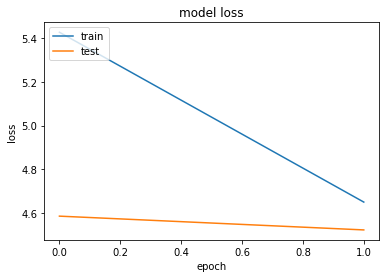

In [25]:
# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
# load model
encoder_model = load_model('encoder_model.h5')
# summarize model.
encoder_model.summary()

Model: "Encoder-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder-Input (InputLayer)   (None, 16)                0         
_________________________________________________________________
Body-Word-Embedding (Embeddi (None, 16, 200)           2090000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500)               902000    
Total params: 2,992,000
Trainable params: 902,000
Non-trainable params: 2,090,000
_________________________________________________________________


/Users/shashikumar/miniconda3/envs/env_icd/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Reverse tokenizer

In [27]:
# Creating a reverse dictionary
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)


In [28]:
def rowNorm(matrix):
    return normalize(matrix, axis=1, norm='l2')

### Check decoded sequence

In [29]:
### Enocode and Decode
def encode_decode(sentences):
    for sent in sentences:
        seq = tokenizer.texts_to_sequences([sent])
        pad_seq = pad_sequences(seq, MAX_SEQUENCE_LENGTH, padding='post')
        print("PAD_seq ", pad_seq)
        sentence_vec = encoder_model.predict(pad_seq)[0]
        # print(sentence_vec.shape)
        decoded_seq = seq2seq_Model.predict(pad_seq)[0]
        # print("decoded_seq = ", decoded_seq.shape)
        decoded_sent = np.argmax(decoded_seq, axis = 1)
        print("Decoded Sent: ", decoded_sent)
        my_texts = list(map(sequence_to_text, [decoded_sent]))
        print("INPUT: ", sent)
        print("OUTPUT: ", [x for x in my_texts[0] if x != None])
        print('-'* 10)

In [30]:
FIRST_K_EXAMPLES = 20
for ind in range(FIRST_K_EXAMPLES):
    print("S - %d", ind )
    encode_decode([icd_sentences[ind]])

S - %d 0
PAD_seq  [[1613 4052  167    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Decoded Sent:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
INPUT:  Unspecified essential hypertension
OUTPUT:  []
----------
S - %d 1
PAD_seq  [[ 441   74  126 1613    0    0    0    0    0    0    0    0    0    0
     0    0]]
Decoded Sent:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
INPUT:  Congestive heart failure, unspecified
OUTPUT:  []
----------
S - %d 2
PAD_seq  [[191 261   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
Decoded Sent:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
INPUT:  Atrial fibrillation
OUTPUT:  []
----------
S - %d 3
PAD_seq  [[ 115 4053    4 2973  115   89    0    0    0    0    0    0    0    0
     0    0]]
Decoded Sent:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
INPUT:  Coronary atherosclerosis of native coronary artery
OUTPUT:  []
----------
S - %d 4
PAD_seq  [[ 150  591  126 1613    0    0    0    0    0    0    0    0    0    0
     0    0]]
Decoded Sent:  [0 0 0 0 0 0 0 0 0 

In [31]:
### Encode all ICD codes
def generate_sentence_encoding(sentences, l2_normalized = False):
    seq = tokenizer.texts_to_sequences(sentences)
    pad_seq = pad_sequences(seq, MAX_SEQUENCE_LENGTH, padding='post')
    icd_encoded = encoder_model.predict(pad_seq)
    print(icd_encoded.shape)
    # Normalize
    if l2_normalized:
        norm_icd_encoded = normalize(icd_encoded, norm = 'l2', axis = 1)
        return norm_icd_encoded
    else:
        return icd_encoded

In [32]:
norm_icd_encoded = generate_sentence_encoding(icd_sentences, l2_normalized= True)

(100, 500)


### TOP_k ICD given a complete DD

In [33]:
def generate_binary(icd_index_list, total_icd = NUM_ICD_CODES):
    binary_icd = np.zeros(total_icd)
    for x in icd_index_list:
        binary_icd[x] = 1
        
    return binary_icd

In [34]:
# TODO: threshold based assignment

def top_ICD(text, top_k = 2, thre= THRESHOLD):  
    sentences = sent_tokenize(text)
    seq = tokenizer.texts_to_sequences(sentences)
    pad_seq = pad_sequences(seq, MAX_SEQUENCE_LENGTH, padding='post')
    sentence_vec = encoder_model.predict(pad_seq)
    
    #normalize
    norm_sentence_vec = normalize(sentence_vec, norm = 'l2', axis = 1)
    kernel_matrix = pairwise.linear_kernel(norm_sentence_vec, norm_icd_encoded)
    top_k_sim_code = np.flip(kernel_matrix.argsort(axis = 1)[:, - top_k:], 1)
    
    icd_list = list(set(i for j in top_k_sim_code for i in j))

    return icd_list
    

In [35]:
f_t = "i have cholera and in past i also had diabetes mellitus." 
top_ICD(f_t, top_k = 2)

[19, 69]

### Results (Precision, recall, f1-measure, Support)

In [36]:
# TOP_K_PER_SENTENCE = 10

In [37]:
actu_icd_x = df_DD['ICD9_CODE'][0][2:-2].split("', '")
icd_id = [dict_code_index[x] for x in actu_icd_x if x in icd_codes]
print("ACT ", actu_icd_x)
print("TOTAL ", icd_codes)
print(sum(generate_binary(icd_id)))

ACT  ['5160', '3485', '51851', '486', '2762', '5180', '5121', '99701', '3481', 'V8543', '32723', '2724', '4275', 'E8798', '27801', '34510', 'V641', '2767']
TOTAL  ['4019', '4280', '42731', '41401', '5849', '25000', '2724', '51881', '5990', '53081', '2720', '2859', '2449', '486', '2851', '2762', '496', '99592', 'V5861', '5070', '5859', '40390', '311', '3051', '412', '2875', '41071', '2761', 'V4581', '4240', 'V1582', '5119', 'V4582', '40391', 'V290', '4241', '78552', 'V5867', '42789', '32723', '9971', '5845', '2760', '7742', '5180', 'V053', '4168', '49390', '2767', '45829', '2749', '4589', '73300', '78039', '5856', '4271', '4254', '4111', 'V1251', '30000', '3572', '99811', '27800', '7907', 'E8798', '60000', '2930', '41400', '2768', 'V3001', '28521', '4439', 'V4501', '5789', '27651', '27652', 'E8788', '769', '431', '4275', 'V4986', '79902', '70703', '99591', '5715', '2639', 'V103', '42832', '42833', '99812', '42732', 'E8782', 'V1046', '49121', '99859', '5712', '2809', '27801', '42823', '2

In [38]:
import time
start= time.time()
pred_icd = []
actu_icd = [] 
for ind, row in df_DD.iterrows():
    text = row['clean_text']
    icd_top = top_ICD(text, top_k = TOP_K_PER_SENTENCE)
    pred_icd.append(generate_binary(icd_top))

    actu_icd_codes = row['ICD9_CODE'][2:-2].split("', '")
    actu_icd_index = [dict_code_index[x] for x in actu_icd_codes if x in icd_codes]
    actu_icd.append(generate_binary(actu_icd_index))

print("TIME = ", time.time() - start)    

TIME =  37.6810188293457


In [39]:
precision, recall, f1_score, support = precision_recall_fscore_support(actu_icd, pred_icd, average = 'micro')
print(precision, recall, f1_score)

0.04816979906551847 0.42198972099853155 0.08646920545369065


In [40]:
total_actu = sum([sum(i) for i in actu_icd])
total_pred = sum([sum(i) for i in pred_icd])
print("Actual Codes = ", total_actu)
print("Predicted Codes = ",total_pred )

Actual Codes =  5448.0
Predicted Codes =  47727.0


In [41]:
def save_to_csv(filename, row):
    with open(RESULT_FILENAME, 'a') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(row)
        f.close()

### Save Results in CSV file

In [43]:
row = ["MAX_SEQUENCE_LENGTH", "ENCODING_DIM", "NUM_ICD_CODES", "MAX_EPOCHS", "TOP_K_PER_SENTENCE",
       "THRESHOLD", "precision", "recall", "f1_score", "total_act", "total_pred"]

values_to_save = [MAX_SEQUENCE_LENGTH, ENCODING_DIM, NUM_ICD_CODES, NUM_EPOCHS, TOP_K_PER_SENTENCE,
                  THRESHOLD, precision, recall, f1_score, total_actu, total_pred]

if not os.path.isfile(RESULT_FILENAME):
    save_to_csv(RESULT_FILENAME, row)
    
row = [str(round(x,3)) for x in values_to_save ]
print(row)

save_to_csv(RESULT_FILENAME, row)

['16', '500', '100', '2', '10', '-1', '0.048', '0.422', '0.086', '5448.0', '47727.0']


In [44]:
print("Successfully Completed !!! CONGRATS !!!")

Successfully Completed !!! CONGRATS !!!


In [45]:
# 10 - 5 % recall
# 5 - 3.4 % recall, 0.6 % Fscore
# 2 - 2 %   recall, 0.7% Fscore